In [1]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
DIR = "/home/claudio/hdd/git/bachelorThesis/figure_7/"

In [3]:
def tier(p):
    if p <= 99:
        return "Free"
    elif p <= 115:
        return "Best effort"
    elif p <= 119:
        return "Mid"
    elif p <= 359:
        return "Production"
    else:
        return "Monitoring"

def categorical_plot(df, key, title, sorted_xs = None):    
    if sorted_xs == None:
        xs = set()
        lines = []
        for t in [4,5,6,7]:
            xs = xs.union(np.array(df[df["term"] == t][key]).reshape(-1))
        xs = [str(x) for x in sorted(xs)]
    else:
        xs = sorted_xs
        
    plt.figure(figsize=(4,3))
    ax = plt.gca()
    lines = []
    for t in [4,5,6,7]:
        ys = []
        if xs[0] == "-1":
            del xs[0]
        for x in xs:
            partsum = df[(df["term"] != -1) & (df[key] == x)]["count"].sum().astype(int)
            y = df[(df["term"] == t) & (df[key] == x)]["count"]
            ys.append(100 * ((y.values.astype(int)[0] / partsum if partsum > 0 else y.values.astype(int)[0]) if y.any()
                             else 0))
        lines.append(ax.plot(xs,ys, marker='.')[0])

    if key == "tier":
        plt.xlabel("Tier")
    elif key == "priority":
        plt.xlabel("2011 priority")
    elif key == "exectime":
        plt.xlabel("Execution time")
    else:
        plt.xlabel("Machine concurrency")
    
    plt.ylabel("Event rate [%]")
    plt.xticks(xs)
    plt.yticks([0,20,40,60,80,100])
    lgd = plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL"], loc="best",
              bbox_to_anchor=(1,1))
    plt.title(title) 
    plt.savefig('../report/figures/figure_7/%s-%s.pgf' % 
                (key.replace("_", ""), cluster), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

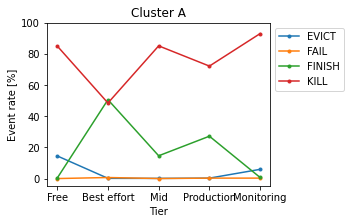

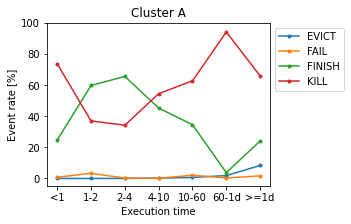

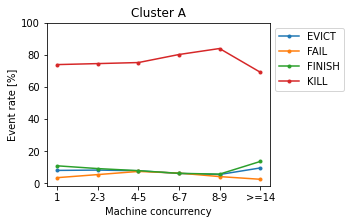

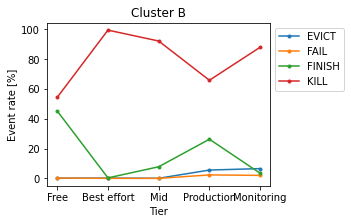

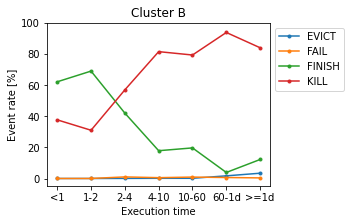

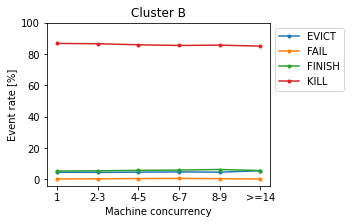

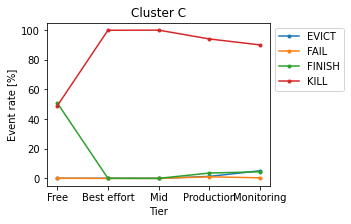

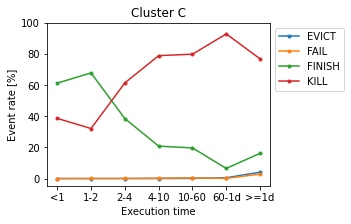

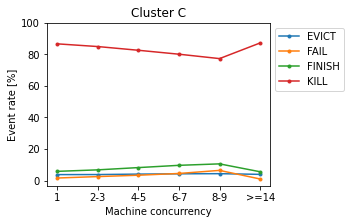

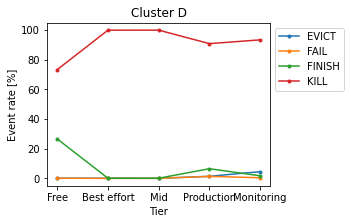

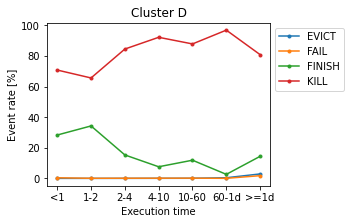

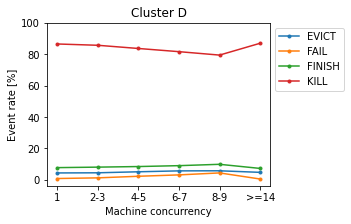

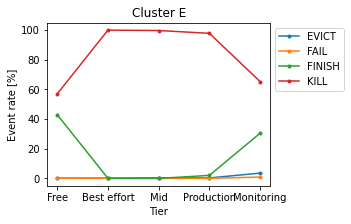

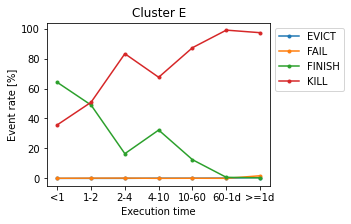

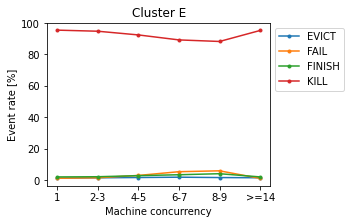

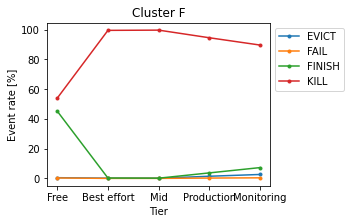

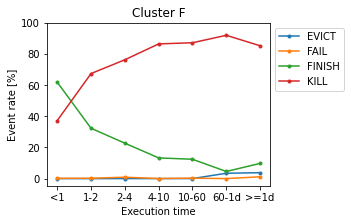

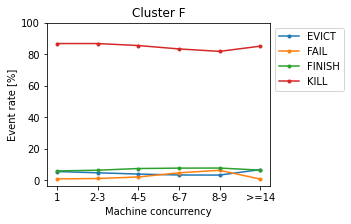

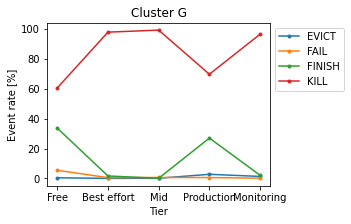

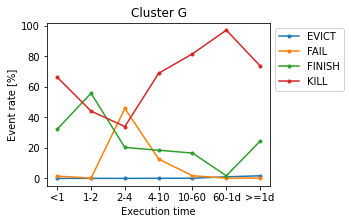

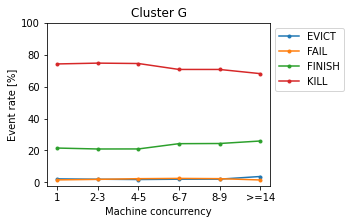

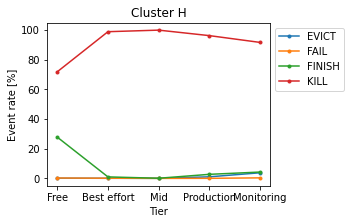

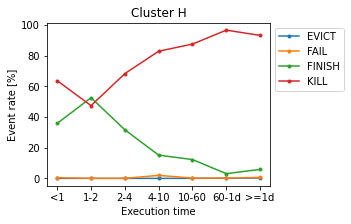

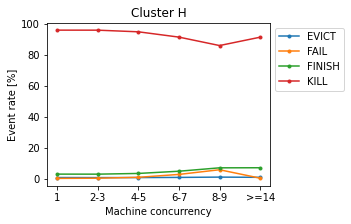

In [4]:
dfatot = None
dfbtot = None
dfctot = None

for cluster in "abcdefgh":
    # Processing figure 7a
    
    dfa = pd.read_csv(glob.glob(DIR + cluster + "_priority/part-*")[0], header=None,
                    names=["term", "priority", "count"])
    dfa["tier"] = dfa["priority"].apply(tier)
    dfa = dfa[dfa["priority"].ge(0)]
    dfa = dfa.groupby(["tier", "term"]).sum().reset_index()
    dfa = dfa[dfa["term"].isin(range(4,8))]
    del dfa["priority"]
    if dfatot is None:
        dfatot = dfa
    else:
        dfatot = dfatot.append(dfa)
    
    xs = ["Free", "Best effort", "Mid", "Production", "Monitoring"]
    categorical_plot(dfa, "tier", "Cluster " + cluster.upper(), xs)
    
    # Processing figure 7b
    
    dfb = pd.read_csv(glob.glob(DIR + cluster + "_exectime/part-*")[0], header=None,
                names=["term", "ignore", "exectime", "count"])
    del dfb["ignore"]
    dfb = dfb.sort_values(["term", "exectime"])
    if dfbtot is None:
        dfbtot = dfb
    else:
        dfbtot = dfbtot.append(dfb)
    
    xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
    categorical_plot(dfb, "exectime", "Cluster " + cluster.upper(), xs)

    # Processing figure 7c
    
    bins = ["1", "2-3", "4-5", "6-7", "8-9", "10-11", "12-13", ">=14"]
    bin_max = [3, 5, 7, 9, 11, 13]
    def map_bins(value):
        for i, m in enumerate(bin_max):
            if value < m:
                return bins[i-1]
        return bins[-1]
    
    dfc = pd.read_csv(DIR + cluster + "_figure7c.csv", header=0)
    dfc = dfc.sort_values(["term", "n_exec"])
    dfc = dfc[dfc["n_exec"] > 0]
    dfc["n_exec"] = dfc["n_exec"].map(map_bins)
    dfc = dfc.groupby(["term", "n_exec"]).sum().reset_index()
    categorical_plot(dfc, "n_exec", "Cluster " + cluster.upper())
    if dfctot is None:
        dfctot = dfc
    else:
        dfctot = dfctot.append(dfc)

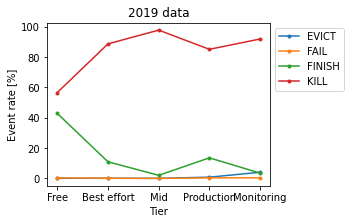

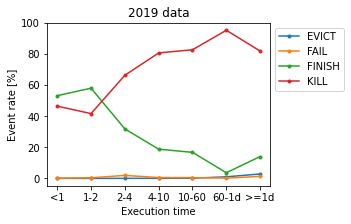

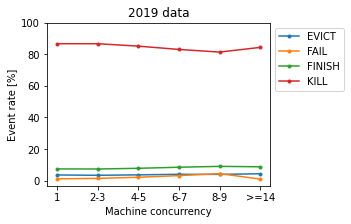

In [5]:
cluster = "all"
        
dfatot = dfatot.groupby(["tier", "term"]).sum().reset_index()
dfbtot = dfbtot.groupby(["term", "exectime"]).sum().reset_index()
dfctot = dfctot.groupby(["term", "n_exec"]).sum().reset_index()

xs = ["Free", "Best effort", "Mid", "Production", "Monitoring"]
categorical_plot(dfatot, "tier", "2019 data", xs)

xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
categorical_plot(dfbtot, "exectime", "2019 data", xs)

categorical_plot(dfctot, "n_exec", "2019 data")

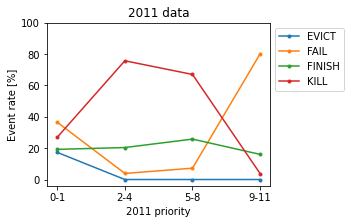

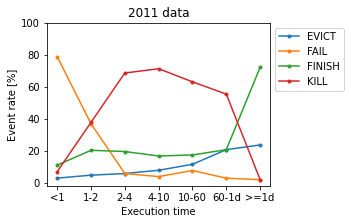

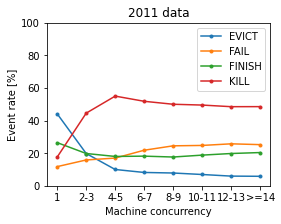

In [6]:
def malusa(l, r):
    return [a for a in itertools.chain(*[[b for x in range(r)] for b in l])]

dfa11 = {'term': [x for x in range(4,8)] * 4,
         'priority': malusa(["0-1", "2-4", "5-8", "9-11"], 4),
         'count': [18, 38, 20, 28,
                   0, 4, 21, 78,
                   0, 7, 25, 65, 
                   0, 85, 17, 4]}
dfa11 = pd.DataFrame(data=dfa11, columns=dfa11.keys())

dfc11 = {'term': [x for x in range(4,8)] * 8,
         'n_exec': malusa(["1", "2-3", "4-5", "6-7", "8-9", "10-11", "12-13", ">=14"], 4),
         'count': [45,12,27,18,
                   20,16,20,45,
                   10,17,18,55,
                   9,24,20,57,
                   8,25,18,51,
                   7,25,19,50,
                   6,26,20,49,
                   6,26,21,50]}
dfc11 = pd.DataFrame(data=dfc11, columns=dfc11.keys())

dfb11 = {'term': [x for x in range(4,8)] * 7,
         'exectime': malusa(["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"], 4),
         'count': [3,78,11,7,
                   5,38,21,39,
                   6,6,20,70,
                   8,4,17,72,
                   12,8,18,65,
                   21,3,21,56,
                   23,2,70,2]}
dfb11 = pd.DataFrame(data=dfb11, columns=dfb11.keys())

cluster = "2011"

categorical_plot(dfa11, "priority", "2011 data")

xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
categorical_plot(dfb11, "exectime", "2011 data", xs)
bins = ["1", "2-3", "4-5", "6-7", "8-9", "10-11", "12-13", ">=14"]
categorical_plot(dfc11, "n_exec", "2011 data", bins)